## Step 1: Data Inspection

Let's load the dataset and inspect its structure.

# Loan Prediction Analysis Notebook

This notebook demonstrates the end-to-end process for a loan prediction project. The steps include:

1. **Data Inspection**: Load and inspect the data.
2. **Data Cleaning & Feature Engineering**: Handle outliers, encode categorical features, and engineer new features.
3. **Model Building & Evaluation**: Train Logistic Regression and Random Forest models, evaluate them, and plot ROC curves and confusion matrices.

Let's begin!

In [1]:
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, MinMaxScaler



# For reproducibility
np.random.seed(42)

In [2]:
# Load the dataset
df = pd.read_csv('loan_data.csv')

# Basic information about the dataset
print('Dataset Info:')
print(df.info())

# Show the first 5 rows
print('\nFirst 5 rows:')
print(df.head())

# Check for missing values
print('\nMissing values:')
print(df.isnull().sum())

# Describe numeric and categorical columns
print('\nNumeric Summary:')
print(df.describe())

print('\nCategorical Summary:')
print(df.describe(include=['O']))

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defa

## Step 2: Data Cleaning & Feature Engineering

We will now handle outliers, encode categorical variables, create a new feature (`debt_to_income`), and scale the numerical features.

In [3]:
# Make a copy of the original dataframe
df_cleaned = df.copy()

### A. OUTLIER HANDLING

# Cap person_age at 100
df_cleaned['person_age'] = df_cleaned['person_age'].clip(upper=100)

# Cap person_income at the 99th percentile to reduce the effect of extreme outliers
income_cap = df_cleaned['person_income'].quantile(0.99)
df_cleaned['person_income'] = df_cleaned['person_income'].clip(upper=income_cap)

# Cap person_emp_exp at 50
df_cleaned['person_emp_exp'] = df_cleaned['person_emp_exp'].clip(upper=50)

### B. ENCODING CATEGORICAL VARIABLES

# Label encode binary columns: person_gender and previous_loan_defaults_on_file
label_encoders = {}
binary_cols = ['person_gender', 'previous_loan_defaults_on_file']
for col in binary_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le

# One-hot encode multi-category columns: person_education, person_home_ownership, loan_intent
df_cleaned = pd.get_dummies(df_cleaned, columns=['person_education', 'person_home_ownership', 'loan_intent'], drop_first=True)

### C. FEATURE ENGINEERING

# Create a new feature: debt_to_income (loan amount divided by income)
df_cleaned['debt_to_income'] = df_cleaned['loan_amnt'] / (df_cleaned['person_income'] + 1)

### D. FEATURE SCALING

# Scale numerical columns
scaler = MinMaxScaler()
num_cols = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
            'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
            'credit_score', 'debt_to_income']
df_cleaned[num_cols] = scaler.fit_transform(df_cleaned[num_cols])

print('Cleaned DataFrame shape:', df_cleaned.shape)
print('\nFirst 5 rows of cleaned data:')
print(df_cleaned.head())

Cleaned DataFrame shape: (45000, 24)

First 5 rows of cleaned data:
   person_age  person_gender  person_income  person_emp_exp  loan_amnt  \
0      0.0250              0       0.242733            0.00   1.000000   
1      0.0125              0       0.016254            0.00   0.014493   
2      0.0625              0       0.016846            0.06   0.144928   
3      0.0375              0       0.272359            0.00   1.000000   
4      0.0500              1       0.220668            0.02   1.000000   

   loan_int_rate  loan_percent_income  cb_person_cred_hist_length  \
0       0.727023             0.742424                    0.035714   
1       0.392318             0.121212                    0.000000   
2       0.510974             0.666667                    0.035714   
3       0.672840             0.666667                    0.000000   
4       0.606996             0.803030                    0.071429   

   credit_score  previous_loan_defaults_on_file  ...  person_education_M

## Step 3: Model Building & Evaluation

We'll now build two models:

- Logistic Regression (baseline)
- Random Forest Classifier

Then, we will evaluate the models using classification metrics and ROC-AUC score.

In [4]:
# Define features and target
X = df_cleaned.drop(columns=['loan_status'])
y = df_cleaned['loan_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### A. Logistic Regression
log_reg = LogisticRegression(max_iter=1000, solver='lbfgs')
log_reg.fit(X_train, y_train)
log_preds = log_reg.predict(X_test)

### B. Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

### C. Evaluation
print('📊 Logistic Regression Evaluation:')
print(classification_report(y_test, log_preds))
print('ROC-AUC Score:', roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1]))
print('Confusion Matrix:\n', confusion_matrix(y_test, log_preds))

print('\n🌲 Random Forest Evaluation:')
print(classification_report(y_test, rf_preds))
print('ROC-AUC Score:', roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))
print('Confusion Matrix:\n', confusion_matrix(y_test, rf_preds))

📊 Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      7000
           1       0.79      0.75      0.77      2000

    accuracy                           0.90      9000
   macro avg       0.86      0.84      0.85      9000
weighted avg       0.90      0.90      0.90      9000

ROC-AUC Score: 0.9559790714285713
Confusion Matrix:
 [[6598  402]
 [ 509 1491]]

🌲 Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      7000
           1       0.91      0.77      0.83      2000

    accuracy                           0.93      9000
   macro avg       0.92      0.87      0.89      9000
weighted avg       0.93      0.93      0.93      9000

ROC-AUC Score: 0.9758331785714286
Confusion Matrix:
 [[6841  159]
 [ 469 1531]]


## Step 4: Plotting ROC Curves and Confusion Matrices

We will now plot the ROC curves and confusion matrices for both models.

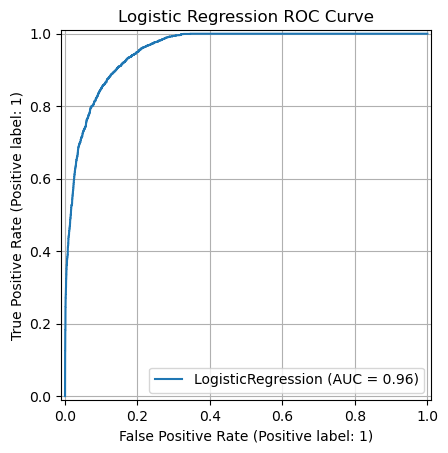

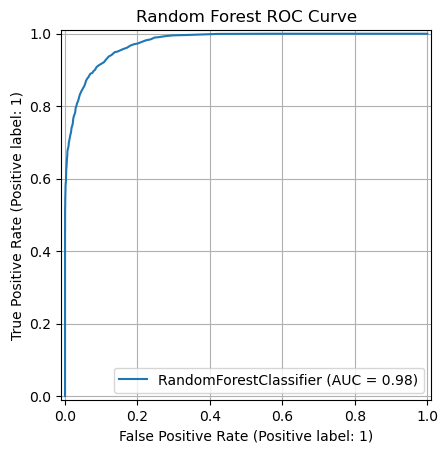

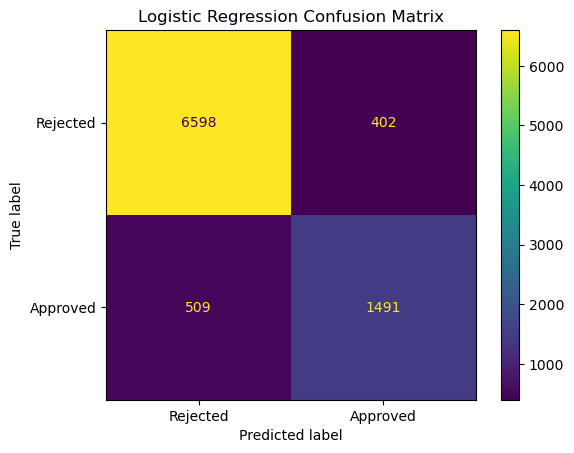

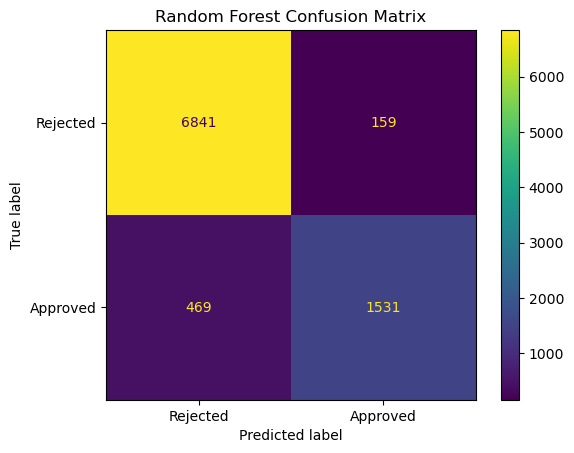

In [5]:
# ROC Curve for Logistic Regression
RocCurveDisplay.from_estimator(log_reg, X_test, y_test)
plt.title('Logistic Regression ROC Curve')
plt.grid(True)
plt.show()

# ROC Curve for Random Forest
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title('Random Forest ROC Curve')
plt.grid(True)
plt.show()

# Confusion Matrix for Logistic Regression
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test, display_labels=['Rejected', 'Approved'])
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, display_labels=['Rejected', 'Approved'])
plt.title('Random Forest Confusion Matrix')
plt.show()

## Step 5: (Optional) Save Trained Models

You can save the trained models for later use using `joblib`.

In [6]:
import joblib

# Save models
joblib.dump(log_reg, 'logistic_model.pkl')
joblib.dump(rf, 'random_forest_model.pkl')
print('Models saved successfully!')

Models saved successfully!
